<a href="https://colab.research.google.com/github/AshutoshDhungana/stock_prediction_LSTM/blob/main/LSTM_Stock_Price_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Mount the drive**

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#**Importing the necessary Libaraies for creating a sentiment analaysis model**

In [10]:
#import the necessary packages for sentiment analysis

import numpy as np
import pandas as pd
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn import naive_bayes
from sklearn.metrics import classification_report
import re
import string
import seaborn as sns
import matplotlib.pyplot as plt


#**Importing the data sets**

In [11]:
raw_news = pd.read_csv('/content/drive/MyDrive/Dataset_colab/Stock_Market_LSTM/raw_news_data.csv')
raw_stock = pd.read_csv('/content/drive/MyDrive/Dataset_colab/Stock_Market_LSTM/raw_stock_data.csv')

##Displaying the datasets:

In [12]:
raw_news

,Date,Title
0,11/15/19,Nepal Insurance Company posts net profit of Rs...
1,11/15/19,Look at the major highlights from the first qu...
2,11/15/19,Sanima Life Insurance and Mahalaxmi Life Insur...
3,11/15/19,NMB Bank was traded the most this week; Sabaik...
4,11/15/19,Ganapati Microfinance announces 3rd AGM on Pou...
...,...,...
42105,3/25/11,Close date of Corporate Development Bank
42106,3/25/11,NRB bid to bail out crisis-hit BFIs
42107,3/25/11,Auction Shares of Shikhar Finance Ltd
42108,3/25/11,Fresh scandal in Gurkha Development Bank


In [13]:
raw_stock

,Date,LTP,Open,High,Low,Quantity,Turnover,Change
0,3/25/2011,135,133,135,132,2560,342820,-2
1,3/27/2011,134,135,135,134,2110,284040,1
2,3/28/2011,130,134,134,130,1288,169336,4
3,3/29/2011,127,130,129,127,1390,178760,3
4,3/30/2011,129,127,129,125,1261,161332,-2
...,...,...,...,...,...,...,...,...
1986,11/10/2019,419,414,419,410,11958,4968204,-5
1987,11/11/2019,421,414,421,414,3581,1494243,-7
1988,11/12/2019,417,425,425,417,12550,5243574,8
1989,11/13/2019,416,414,417,413,23563,9781256,-2


#**Data Pre Processing**

##Cleaning the datasets


1. Let's frist start with cleaning the data, off of null values, duplicate values and lets correct the format for the Date for ease of use later

In [14]:
raw_news.dropna(subset=['Date', 'Title'], inplace=True)  #delete empty
raw_news.drop_duplicates(subset=['Title'], inplace=True)  #delete duplicate
raw_news['Date'] = pd.to_datetime(raw_news['Date'])   #Date Format Correct

<ipython-input-14-d5f6bc1cc89c>:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  raw_news['Date'] = pd.to_datetime(raw_news['Date'])   #Date Format Correct


2. Now in the title column of the raw_news data set, lets clean the **"title"** off of the blank spaces, and any type of symbols and also make them all lower case


In [15]:
import re
raw_news['Cleaned_Title'] = raw_news['Title'].apply(lambda x: re.sub(r'[^a-zA-Z\s]', '', x))


In [16]:
raw_news['Cleaned_Title'] = raw_news['Cleaned_Title'].str.lower()


##Tokenization and Processing the Titles

In [17]:
nltk.download('stopwords')
nltk.download('punkt_tab')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [18]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)

raw_news['Processed_Title'] = raw_news['Cleaned_Title'].apply(preprocess_text)


###Aggregating the News Title by Date:

In [19]:
aggregated_news = raw_news.groupby('Date')['Processed_Title'].apply(' '.join).reset_index()


##Further Cleaning the Datasets

In [20]:
raw_stock.dropna(inplace=True)


In [21]:
raw_stock['Date'] = pd.to_datetime(raw_stock['Date'])


In [22]:
raw_stock['Change_Percentage'] = (raw_stock['Change'] / raw_stock['LTP']) * 100


In [23]:
raw_stock['Price_Range'] = raw_stock['High'] - raw_stock['Low']


In [24]:
raw_stock.sort_values(by='Date', inplace=True)


##Merging the Datasets

Since the data that we need for the LSTM model is present in two different files we are mering them both.
<br><br>
We need them ordered with respect to their dates therefore we merge the data sets ON the 'Date' column, and perform a 'Inner' merge

In [77]:
combined_data = pd.merge(aggregated_news, raw_stock, on='Date', how='inner')


In [26]:
combined_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1991 entries, 0 to 1990
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Date               1991 non-null   datetime64[ns]
 1   Processed_Title    1991 non-null   object        
 2   LTP                1991 non-null   int64         
 3   Open               1991 non-null   int64         
 4   High               1991 non-null   int64         
 5   Low                1991 non-null   int64         
 6   Quantity           1991 non-null   int64         
 7   Turnover           1991 non-null   int64         
 8   Change             1991 non-null   int64         
 9   Change_Percentage  1991 non-null   float64       
 10  Price_Range        1991 non-null   int64         
dtypes: datetime64[ns](1), float64(1), int64(8), object(1)
memory usage: 171.2+ KB


In [27]:
combined_data.to_csv('/content/drive/MyDrive/Dataset_colab/Stock_Market_LSTM/merged_data.csv', index=False)


In [30]:
mergerd_data = pd.read_csv('/content/drive/MyDrive/Dataset_colab/Stock_Market_LSTM/merged_data.csv')

In [31]:
mergerd_data

,Date,Processed_Title,LTP,Open,High,Low,Quantity,Turnover,Change,Change_Percentage,Price_Range
0,2011-03-25,api finance ltd published notice regarding tim...,135,133,135,132,2560,342820,-2,-1.481481,3
1,2011-03-27,march kaski finance ltd issuing right share ap...,134,135,135,134,2110,284040,1,0.746269,1
2,2011-03-28,dcgc cover ufl capital merchant bank finance l...,130,134,134,130,1288,169336,4,3.076923,4
3,2011-03-29,gdb shuts operational counter bhargav bikash b...,127,130,129,127,1390,178760,3,2.362205,2
4,2011-03-30,nrb move court liquidate samjhana finance secr...,129,127,129,125,1261,161332,-2,-1.550388,4
...,...,...,...,...,...,...,...,...,...,...,...
1986,2019-11-10,citizen bank wellequipped building kamaladi ex...,419,414,419,410,11958,4968204,-5,-1.193317,9
1987,2019-11-11,global ime bank continues making stronger pres...,421,414,421,414,3581,1494243,-7,-1.662708,7
1988,2019-11-12,nepse fall point losing today six scrip post t...,417,425,425,417,12550,5243574,8,1.918465,8
1989,2019-11-13,sagarmatha insurance sign health service agree...,416,414,417,413,23563,9781256,-2,-0.480769,4


#**Feature Engineering**

<br>
Now the nest step is extracting the necessary details and parameters that will be necessary later to build the model


##Installing and Importing necessary libraries and tools

In [32]:
pip install vaderSentiment textblob transformers


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 2.1 MB/s eta 0:00:00


In [33]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from textblob import TextBlob
from transformers import pipeline


##Initialize analyzer

In [34]:
analyzer = SentimentIntensityAnalyzer()


##Define sentiment functions

In [35]:
def get_sentiment_vader(text):
    sentiment = analyzer.polarity_scores(text)
    return sentiment['compound']  # Compound score indicates overall sentiment

aggregated_news['Sentiment_Score_VADER'] = aggregated_news['Processed_Title'].apply(get_sentiment_vader)


In [36]:
def get_sentiment_textblob(text):
    sentiment = TextBlob(text).sentiment
    return sentiment.polarity

aggregated_news['Sentiment_Score_TextBlob'] = aggregated_news['Processed_Title'].apply(get_sentiment_textblob)


##Calculate and Visualize average sentiment scores

In [37]:
aggregated_news['Average_Sentiment_Score'] = aggregated_news[['Sentiment_Score_VADER', 'Sentiment_Score_TextBlob']].mean(axis=1)


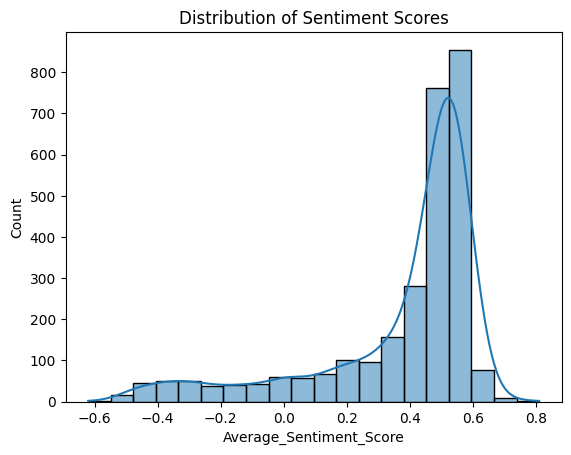

In [79]:
sns.histplot(aggregated_news['Average_Sentiment_Score'], kde=True, bins=20)
plt.title('Distribution of Sentiment Scores')
plt.show()


##Prepare and Merge sentiment data with stock data:

In [39]:
print(aggregated_news[['Date', 'Processed_Title', 'Average_Sentiment_Score']]
      )


           Date                                    Processed_Title  \
0    2011-03-17      cit investment various sector cross r billion   
1    2011-03-25  api finance ltd published notice regarding tim...   
2    2011-03-26  nrb directive grukha development bank employer...   
3    2011-03-27  march kaski finance ltd issuing right share ap...   
4    2011-03-28  dcgc cover ufl capital merchant bank finance l...   
...         ...                                                ...   
2806 2019-11-11  global ime bank continues making stronger pres...   
2807 2019-11-12  nepse fall point losing today six scrip post t...   
2808 2019-11-13  sagarmatha insurance sign health service agree...   
2809 2019-11-14  sunrise bank expands bhajani kailali rd branch...   
2810 2019-11-15  nepal insurance company post net profit r cror...   

      Average_Sentiment_Score  
0                    0.000000  
1                    0.537814  
2                    0.076053  
3                    0.201064  

In [40]:
aggregated_news_sentiment = aggregated_news[['Date', 'Processed_Title', 'Average_Sentiment_Score']]


In [41]:
merged_data = pd.merge(aggregated_news_sentiment, raw_stock, on='Date', how='inner')

In [42]:
merged_data.columns

Index(['Date', 'Processed_Title', 'Average_Sentiment_Score', 'LTP', 'Open',
       'High', 'Low', 'Quantity', 'Turnover', 'Change', 'Change_Percentage',
       'Price_Range'],
      dtype='object')

#**Correlation Analysis**

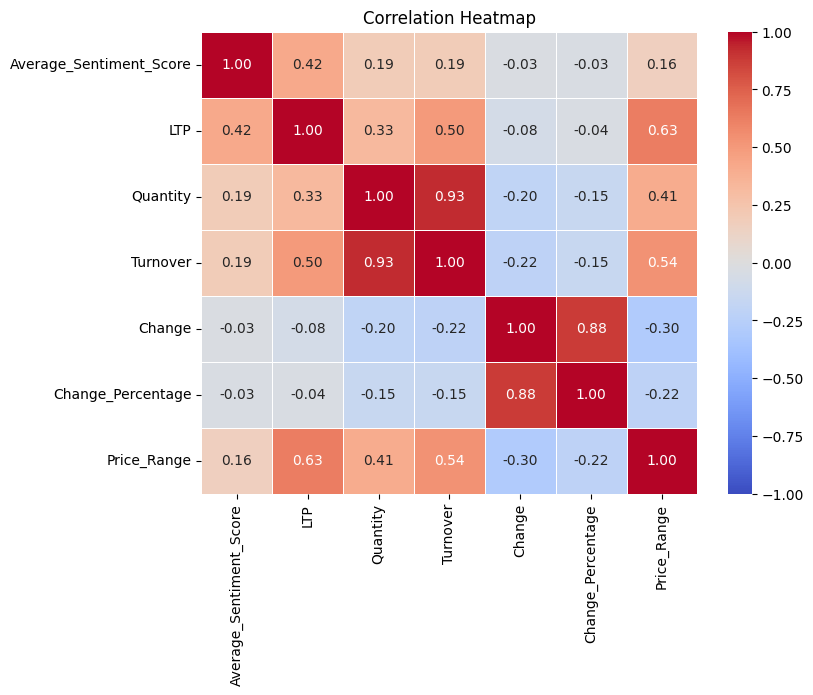

In [80]:
correlation_matrix = merged_data[['Average_Sentiment_Score', 'LTP', 'Quantity', 'Turnover', 'Change', 'Change_Percentage', 'Price_Range']].corr()


# Create a heatmap for the correlation matrix
plt.figure(figsize=(8, 6))  # Optional: Adjust figure size
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt=".2f", linewidths=0.5)

# Show the heatmap
plt.title("Correlation Heatmap")
plt.show()


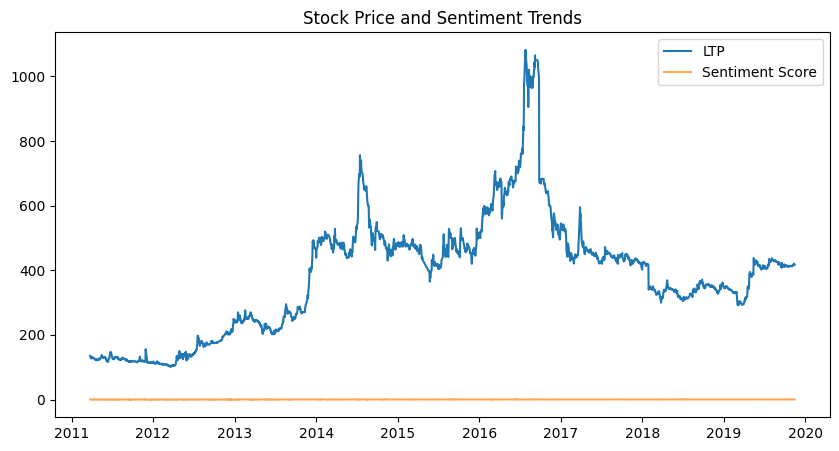

In [44]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(merged_data['Date'], merged_data['LTP'], label='LTP')
plt.plot(merged_data['Date'], merged_data['Average_Sentiment_Score'], label='Sentiment Score', alpha=0.7)
plt.legend()
plt.title('Stock Price and Sentiment Trends')
plt.show()


#**Time Series Data Preparation**

##Sort data by date:

In [45]:
merged_data.sort_values(by='Date', inplace=True)


##Create lag features:

In [46]:
for lag in range(1, 6):  # Create features for the past 5 days
    merged_data[f'Sentiment_Lag_{lag}'] = merged_data['Average_Sentiment_Score'].shift(lag)
    merged_data[f'LTP_Lag_{lag}'] = merged_data['LTP'].shift(lag)


In [47]:
merged_data.dropna(inplace=True)

#**Scaling and Preparing Data**

In [48]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(merged_data.drop(['Date', 'Processed_Title'], axis=1))
# Get the column names excluding 'Date' and 'Processed_Title'
scaled_columns = merged_data.drop(['Date', 'Processed_Title'], axis=1).columns
scaled_data = pd.DataFrame(scaled_features, columns=scaled_columns)
scaled_data['Date'] = merged_data['Date'].values  # Add the Date back

##Define features and target:

In [49]:
features = [col for col in scaled_data.columns if 'Lag' in col]
target = 'LTP'

X = scaled_data[features].values
y = scaled_data[target].values


In [50]:
import numpy as np

def create_sequences(X, y, time_steps=5):
    X_seq, y_seq = [], []
    for i in range(len(X) - time_steps):
        X_seq.append(X[i:i + time_steps])
        y_seq.append(y[i + time_steps])
    return np.array(X_seq), np.array(y_seq)

time_steps = 10  # Number of previous time steps to consider
X_seq, y_seq = create_sequences(X, y, time_steps)


#**Train-Test Split**

In [51]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42, shuffle=False)


#**LSTM Model Building**

##Import TensorFlow and define LSTM model:

In [52]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout


In [53]:
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25, activation='relu'),
    Dense(1)  # Single output for regression
])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


##Compile and summarize the model:

In [54]:
model.compile(optimizer='adam', loss='mse', metrics=['mae'])


In [55]:
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 10, 50)              │          12,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 10, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 25)                  │           1,275 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              26 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 33,701 (131.64 KB)

 Trainable params: 33,701 (131.64 KB)

 Non-trainable params: 0 (0.00 B)

##Train the model:

In [56]:
epochs = 50
batch_size = 32



In [57]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test),
                    epochs=epochs, batch_size=batch_size, verbose=1)


Epoch 1/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 12s 52ms/step - loss: 0.0271 - mae: 0.1175 - val_loss: 0.0018 - val_mae: 0.0411
Epoch 2/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - loss: 0.0045 - mae: 0.0457 - val_loss: 2.1051e-04 - val_mae: 0.0109
Epoch 3/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.0039 - mae: 0.0439 - val_loss: 2.9694e-04 - val_mae: 0.0144
Epoch 4/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - loss: 0.0038 - mae: 0.0428 - val_loss: 4.4701e-04 - val_mae: 0.0170
Epoch 5/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0029 - mae: 0.0360 - val_loss: 3.7016e-04 - val_mae: 0.0149
Epoch 6/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0022 - mae: 0.0331 - val_loss: 6.8891e-04 - val_mae: 0.0229
Epoch 7/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0030 - mae: 0.0359 - val_loss: 5.2673e-04 - val_mae: 0.0194
Epoch 8/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0031 - mae: 0.0390 - val_loss: 7.3016e-04 - val_mae: 0.0241
Epoch 9/50
50/50 ━━━━━━━━━━━━━━━━━━

##Evaluate the model:

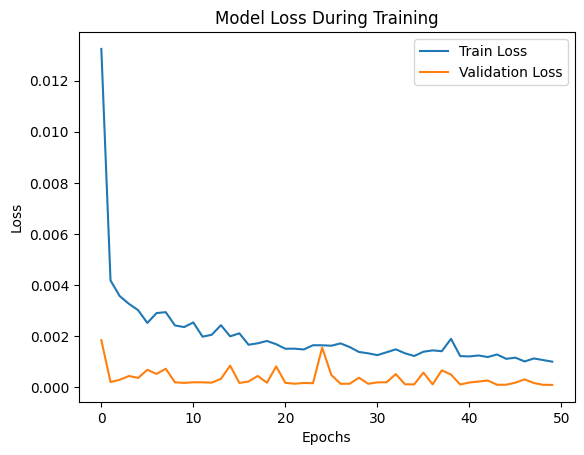

In [58]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss During Training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [59]:
test_loss, test_mae = model.evaluate(X_test, y_test, verbose=0)
print(f'Test Loss: {test_loss:.4f}, Test MAE: {test_mae:.4f}')


Test Loss: 0.0001, Test MAE: 0.0068


##Make predictions:

In [60]:
predictions = model.predict(X_test)


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step


In [61]:
# Create a new scaler for the target variable
target_scaler = MinMaxScaler()

# Fit the scaler only to the target variable in the training data
target_scaler.fit(y_train.reshape(-1, 1))  # Reshape to a 2D array

# Inverse transform y_test and predictions using the target scaler
y_test_unscaled = target_scaler.inverse_transform(y_test.reshape(-1, 1))
predictions_unscaled = target_scaler.inverse_transform(predictions)

In [62]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

rmse = np.sqrt(mean_squared_error(y_test_unscaled, predictions_unscaled))
r2 = r2_score(y_test_unscaled, predictions_unscaled)
print(f'RMSE: {rmse:.4f}, R²: {r2:.4f}')


RMSE: 0.0099, R²: 0.9468


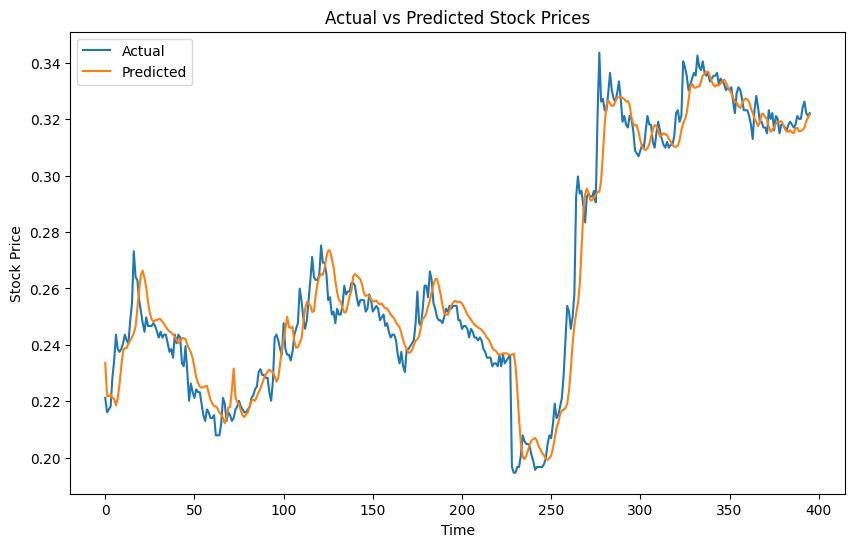

In [63]:
plt.figure(figsize=(10, 6))
plt.plot(y_test_unscaled, label='Actual')
plt.plot(predictions_unscaled, label='Predicted')
plt.title('Actual vs Predicted Stock Prices')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()


##Save the model:

In [64]:
model.save('lstm_stock_model.h5')


#**Testing the model against other models**

In [65]:
merged_data['Target_Class'] = (merged_data['Change'] > 0).astype(int)


In [66]:
features = [col for col in merged_data.columns if 'Lag' in col]
target = 'Target_Class'

X = merged_data[features].values
y = merged_data[target].values


In [67]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)


In [68]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


##Logistic Regression:

In [69]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression()


In [70]:
log_reg.fit(X_train, y_train)


LogisticRegression()

In [71]:
y_pred_log = log_reg.predict(X_test)


In [72]:
# prompt: Find the rmse mae and r squared for the above logistic regression model

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Assuming y_test and y_pred_log are defined from the logistic regression

# Check lengths of y_test and y_pred_log
print(f"Length of y_test: {len(y_test)}")
print(f"Length of y_pred_log: {len(y_pred_log)}")

# If lengths are different, investigate and fix the issue before proceeding
# Here's an example of a fix if y_pred_log is longer:
if len(y_pred_log) > len(y_test):
    y_pred_log = y_pred_log[:len(y_test)]
elif len(y_pred_log) < len(y_test):
    y_test = y_test[:len(y_pred_log)]

rmse = np.sqrt(mean_squared_error(y_test, y_pred_log))
mae = mean_absolute_error(y_test, y_pred_log)
r2 = r2_score(y_test, y_pred_log)

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R-squared: {r2}")

Length of y_test: 398
Length of y_pred_log: 398
RMSE: 0.6516311192522112
MAE: 0.42462311557788945
R-squared: -0.7379912663755461


##SVM Model:

In [73]:
from sklearn.svm import SVC

svm_model = SVC(kernel='rbf')  # RBF kernel for non-linear separation


In [74]:
svm_model.fit(X_train, y_train)


SVC()

In [75]:
y_pred_svm = svm_model.predict(X_test)


In [76]:
# prompt: find rmse mae and r sqared for the svm model above

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Assuming y_test and y_pred_svm are defined from the SVM model

# Check lengths of y_test and y_pred_svm
print(f"Length of y_test: {len(y_test)}")
print(f"Length of y_pred_svm: {len(y_pred_svm)}")

# If lengths are different, investigate and fix the issue before proceeding
# Here's an example of a fix if y_pred_svm is longer:
if len(y_pred_svm) > len(y_test):
    y_pred_svm = y_pred_svm[:len(y_test)]
elif len(y_pred_svm) < len(y_test):
    y_test = y_test[:len(y_pred_svm)]

rmse = np.sqrt(mean_squared_error(y_test, y_pred_svm))
mae = mean_absolute_error(y_test, y_pred_svm)
r2 = r2_score(y_test, y_pred_svm)

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R-squared: {r2}")

Length of y_test: 398
Length of y_pred_svm: 398
RMSE: 0.6592976314489313
MAE: 0.43467336683417085
R-squared: -0.7791271543370974


#**Conclusion**

In this project, we aimed to predict stock prices using various models, including an LSTM model, Logistic Regression, and an SVM model. We utilized sentiment analysis of news headlines and historical stock data to create features that could potentially influence stock price movements. Here's a summary of our findings:

1. **LSTM Model:**
The LSTM model performed exceptionally well in predicting stock prices with the following metrics:

* Test Loss: 0.0001
* Mean Absolute Error (MAE): 0.0068
* Root Mean Squared Error (RMSE): 0.0099
* R² Score: 0.9468

These results indicate that the LSTM model was able to capture the underlying patterns and trends in the data with high accuracy, making it a robust choice for stock price prediction.

2. **Logistic Regression:**
The Logistic Regression model produced the following metrics:

* RMSE: 0.6516
* MAE: 0.4246
* R² Score: -0.7380

The negative R² score indicates that the model performed poorly and failed to capture the variance in the data. Logistic Regression may not be suitable for this type of time-series data due to its linear nature and the complexity of stock price movements.

3. **SVM Model:**
The SVM model had similar results to Logistic Regression, with the following metrics:

* RMSE: 0.6593
* MAE: 0.4347
* R² Score: -0.7791

The SVM model also struggled to capture the nuances of the data, as indicated by the negative R² score. This suggests that SVM may not be the optimal choice for predicting stock prices when dealing with sequential and time-dependent data.


# **Key Takeaways**


* The LSTM model significantly outperformed both Logistic Regression and SVM, demonstrating the effectiveness of recurrent neural networks for time-series forecasting tasks.

* Sentiment analysis proved to be a valuable feature in conjunction with historical stock data, helping the LSTM model make accurate predictions.

* Traditional machine learning models like Logistic Regression and SVM may not be suitable for complex and sequential data like stock prices due to their inability to capture long-term dependencies and patterns.

<br>

Future improvements could include experimenting with other deep learning architectures (such as GRU or Transformer-based models) and incorporating additional features like macroeconomic indicators or social media sentiment for more comprehensive predictions.